## Классификация на размеченном вручную датасете.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from string import digits
import re
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix

Заготавливаем стоп-слова

In [3]:
stop_words = stopwords.words('russian')
stop_words.extend(['это', '–', '-', 'фонд', 'наш', 'помощь', 'помогать',
                   'помочь', 'поддержать', 'поддержка', 'средство', 'который', 'весь',
                   'благотворительный', 'деньги', 'рубль', 'год', 'день', 'тысяча',
                   'ваш', 'сегодня', 'завтра', 'этот', 'дать', 'проект', 'свой' ])

Достаем данные

In [4]:
df = pd.read_csv("/Users/liza/PycharmProjects/Planeta_project/plset_fin_upd_clustered.tsv", sep ="\t")
df = df.drop(df.columns[0:2], axis=1)
df = df.rename_axis(None, axis=1).rename_axis('Id', axis=1)

Это тексты и характеристики благотворительных сборов на краудфандинговой площадке planeta.ru
Это 2038 текстов, которым присвоены категории: частично с помощью кластеризации и частично вручную.
В этой тетрадке мы будем учить модель для классификации текстов по категориям.

In [5]:
df.head()
set(df.Category)

{'активизм_просвещение_профилактика',
 'бездомные_кризис',
 'взрослые_лечение_реабилитация',
 'дети_лечение_реабилитация',
 'животные',
 'заключенные',
 'малоимущие_бедность',
 'мечты_подарки_праздники',
 'наука_история_культура',
 'паллиатив_уход',
 'пожилые_ветераны',
 'развитие_нко_инфраструктура',
 'семейный_кризис',
 'сироты_дети_из_неблагополучных семей',
 'социализация_возможности',
 'экология'}

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

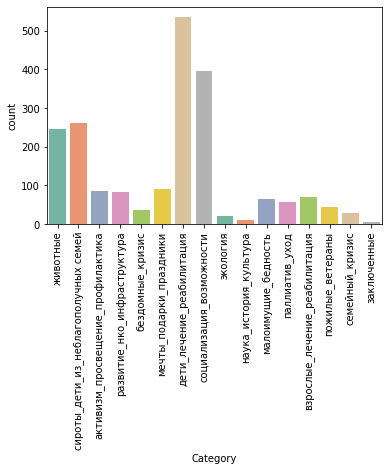

In [6]:
sns.countplot(x=df['Category'], data=df, palette="Set2")
plt.xticks(rotation = '90')

Функция для предобработки текстов с вариантами: слова, лемматизация или стемминг. 

- Лемматизация сильно улучшает MultinomailNB, но он все равно в итоге уступает LR (зато работает очень быстро).
- Регрессию лемматизация и стемминг чуть-чуть улучашют (хотя могут и ухудшать при других параметрах). Удлиняют время работы векторайзера. 

Оставляю леммы, т.к. все-таки улучшение есть и получается более внятный вывод коэффициентов. 

In [7]:
def prep(text):
    clean_text = text.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~«»№!—'))
    clean_text = clean_text.translate(str.maketrans('', '', digits))
    clean_text = re.sub("-", " ", clean_text)
    #clean_text = re.sub("[a-zA-Z]", "", clean_text)  # исключаем слова латиницей
    clean_text = clean_text.lower()
    clean_text = clean_text.split()
    
    #words = [word for word in clean_text if word not in stop_words]
    #return words
    
    lemmas = [morph_analyzer.parse(word)[0].normal_form for word in clean_text]
    lemmas = [word for word in lemmas if word not in stop_words]
    return lemmas
    
    #ниже - альтернатива лемматицации, можно их переключать (за/раскомменчивать)
    #stemmer = RussianStemmer()
    #stemmed_words = [stemmer.stem(word) for word in clean_text]
    #return stemmed_words

Векторизация текстов.

- CountVectorizer на всех моделях показал себя лучше, чем TfidfVectorizer, поэтому оставляю его. 
- Word2vec и сокращение размерности в этот раз не стала пробовать, т.к. при кластеризации они не улучшали результат. Здесь тоже большой надежны на них не было. 
- Биграммы не улучшили классификацию ни с CountV, ни c Tfidf, поэтому оставляю униграммы по умолчанию. 
- Уточнение max_df = 0.50 0.30 и min_df = 0.1 от запуска к запуску могут чуть-чуть улучшать или ухудшать выдачу.

In [8]:
vec = CountVectorizer(tokenizer=prep) 
bag_of_words = vec.fit_transform(df.Description)
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df.Category, stratify = df.Category)

#stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.'''

Попробовала модели:

LogisticRegression\n
MultinomialNB\n
TreeClassifier\n
RandomForestClassifier\n
KNeighborsClassifier\n
SVC\n

Эти попытки есть ниже, в подвале тетрадки. Лучший результат у LR, поэтому оставляю ее.

Гиперпараметры для LR были подобраны через gridsearch. Ему в словарь были поданы не все возможные параметры, т.к. это бы заняло слишком много времени. Были взяты выборочно некоторые. Скрипт - в подвале тетрадки. В действительности подобранные параметры срабатывают по-разному: в пределях +1:3% они улучшают или ухудшают выдачу.

In [9]:
lr = LogisticRegression(max_iter=5000) # опционально: C=0.02, class_weight='balanced'
clf = lr.fit(X_train, y_train)

In [11]:
print(classification_report(y_test, clf.predict(X_test), zero_division=0))

                                      precision    recall  f1-score   support

   активизм_просвещение_профилактика       0.60      0.43      0.50        21
                    бездомные_кризис       0.75      1.00      0.86         9
       взрослые_лечение_реабилитация       0.50      0.33      0.40        18
           дети_лечение_реабилитация       0.84      0.93      0.88       134
                            животные       0.97      0.98      0.98        61
                         заключенные       0.00      0.00      0.00         1
                 малоимущие_бедность       0.47      0.47      0.47        17
             мечты_подарки_праздники       0.67      0.61      0.64        23
              наука_история_культура       0.00      0.00      0.00         3
                      паллиатив_уход       0.86      0.86      0.86        14
                    пожилые_ветераны       0.60      0.82      0.69        11
         развитие_нко_инфраструктура       0.55      0.29      

In [17]:
vector = vec.transform(['''В марте 2017 года студент - медик Евгений Косовских начал самостоятельно оказывать медико-профилактическую помощь людям на улице. Вскоре появился проект "Другая медицина".
Еженедельно арендованный минивен с волонтерами выезжает на теплотрассы. В машине мы проводим прием, оказываем помощь в виде простых, но необходимых мер - перевязок ран, выдачи жаропонижающих и обезболивающих безрецептурных лекарств, индивидуальных средств гигиены, теплых носков и др. 
Проводим беседу о профилактике важных и значимых заболеваний, таких как туберкулез, ВИЧ, гепатит B и С. 
Нуждающихся направляем в лечебные учреждения для обследования ФОГ и сдачи анализов на инфекционные заболевания. Также на месте обследуем подопечных с помощью экспресс-тестов на гепатит С и ВИЧ. 
Проводим осмотры на наличие ожогов, обморожений и гангрен.'''])

In [18]:
clf.predict(vector) # тестируем обученную модель на совсем новом тексте

array(['малоимущие_бедность'], dtype=object)

In [35]:
# сколько фичей получилось

index_to_word = {
    ind: word
    for (word, ind)
    in vec.vocabulary_.items()
    }

top_features = sorted(enumerate(clf.coef_[6]), key=lambda pair: pair[1], reverse=True)[:20] # первые ... коэффициентов
#print(top_features) #выдает list of tuples 

print(len(top_features))
#for index, value in top_features:
  print(index_to_word[index], " - ", value)

31627
семья  -  0.33572087771615516
нуждающийся  -  0.2912021434560991
подарок  -  0.2573935430165262
школьный  -  0.23151488682189258
набор  -  0.22920672637509748
портфель  -  0.1951416450886354
дом  -  0.18476208909333358
питание  -  0.17940555308049305
светлана  -  0.1763803978261
ужин  -  0.17443415876688095
х  -  0.15922668226951728
малообеспеченный  -  0.15894095255586252
одежда  -  0.15715576441194065
малоимущий  -  0.1536269624897852
свет  -  0.15193475254981606
самый  -  0.1486684331466898
вещий  -  0.14674666233332456
сайт  -  0.14487896171694684
бесплатно  -  0.14212899862018138
папа  -  0.13821604757982853
машина  -  0.1365398630958721
юридический  -  0.13572600585810843
женщина  -  0.13444848172509807
мебель  -  0.1301087256293734
сбор  -  0.129579212617244
месяц  -  0.12442265537537778
первоклассник  -  0.1241367443303977
рамка  -  0.12375884723397883
рюкзак  -  0.1232650423944617
сумма  -  0.11982446015097324
добро  -  0.11824909897717527
ремонт  -  0.11751458083517968


In [198]:
def get_words_from_idx(indexes): #получить слова по индексу
    return [index_to_word[index] for index in indexes]

def get_features(class_label): # получить пары индекс слова - коэффициент слова в убывающем порядке по коэфф.
    label_transl_dict = {
     'активизм_просвещение_профилактика': 0,
     'бездомные_кризис': 1,
     'взрослые_лечение_реабилитация': 2,
     'дети_лечение_реабилитация': 3,
     'животные': 4,
     'заключенные': 5,
     'малоимущие_бедность': 6,
     'мечты_подарки_праздники': 7,
     'наука_история_культура': 8,
     'паллиатив_уход': 9,
     'пожилые_ветераны': 10,
     'развитие_нко_инфраструктура': 11,
     'семейный_кризис': 12,
     'сироты_дети_из_неблагополучных семей': 13,
     'социализация_возможности': 14,
     'экология': 15}
    
    idx = label_transl_dict[class_label]
    return sorted(enumerate(clf.coef_[idx]), key=lambda pair: pair[1], reverse=True) 
    

def plot_top_features(class_label, max_top_features, color_given): #график для отдельного класса (label)
    idx_coef_list = get_features(class_label=class_label) # функция выдает список кортежей
    idx, coef = zip(*idx_coef_list) 
    '''zip создает объект-итератор, который принимает рез. функции, которая в свою
    очередь вернула список кортежей [(индекс+коэфф)]
    Без фиксированной длины списка было бы невозможно передать элементы итерируемого объекта 
    как отдельные аргументы, не используя *.'''
    top_words = get_words_from_idx(idx[:max_top_features]) 
    # функция сопоставляет индексы с реальными словами, а принимает она итератор idx, созданный выше, он берет указанный слайс
    plt.figure(figsize=(12,4))
    plt.bar(top_words, coef[:max_top_features], color = color_given) #применяется итератор coef
    plt.title(f'Самые значимые признаки в категории: {class_label}')
    plt.xlabel('Признаки')
    plt.ylabel('Коэффициенты')
    plt.xticks(rotation = '60')
    plt.show()   

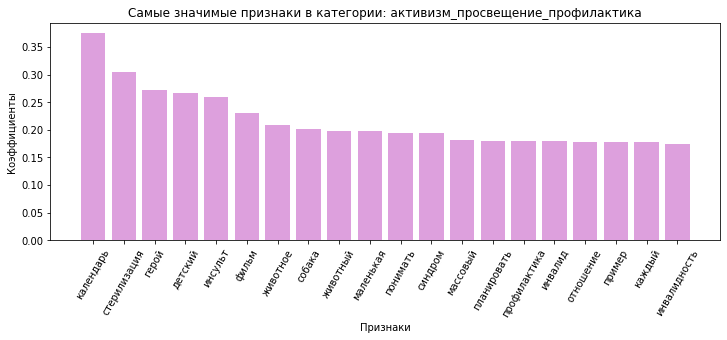

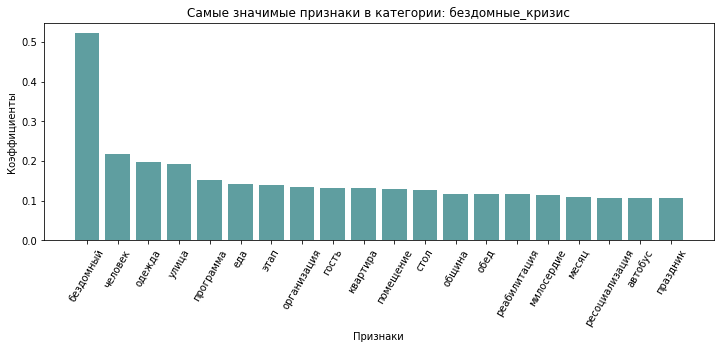

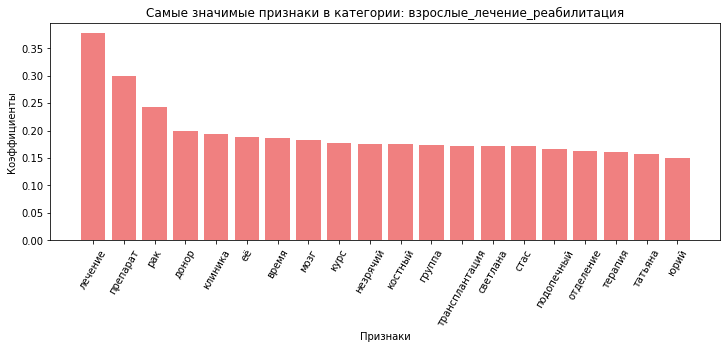

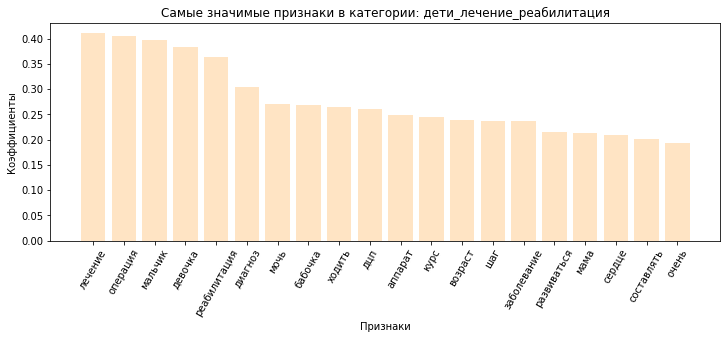

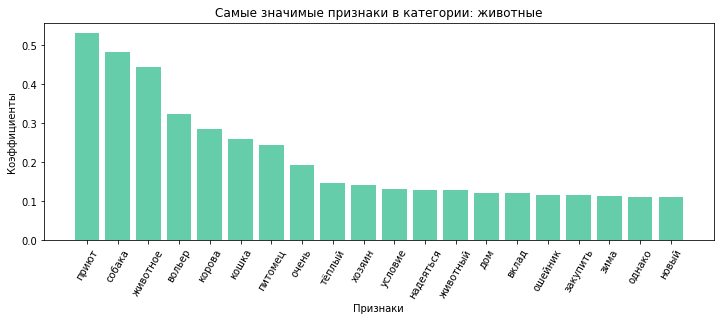

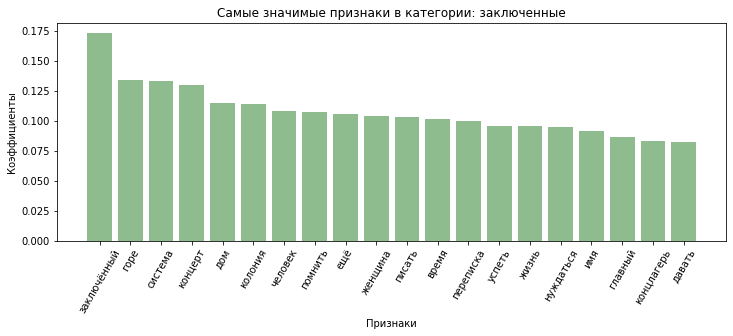

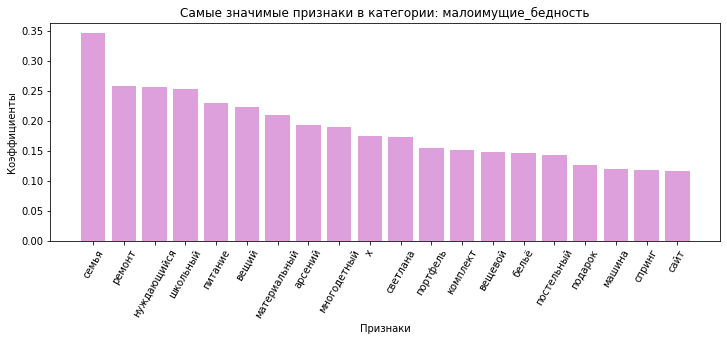

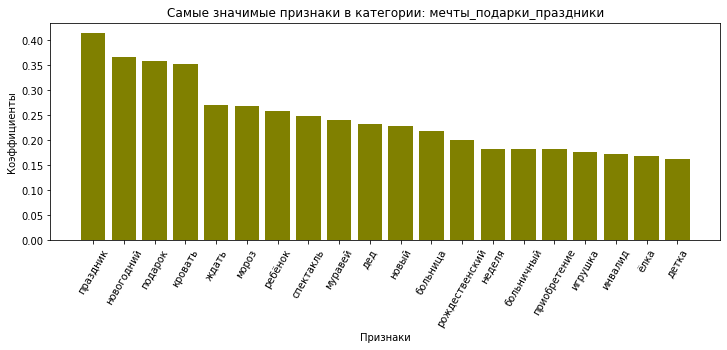

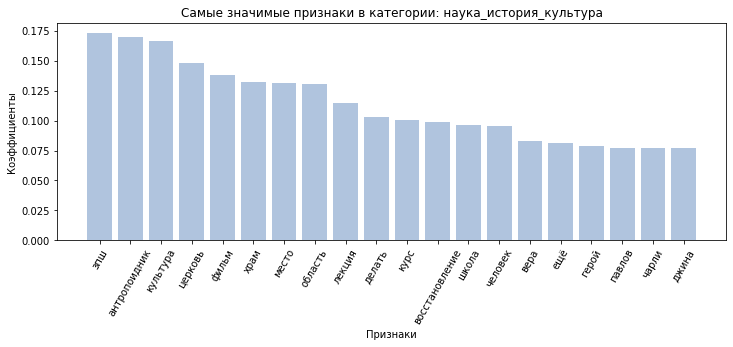

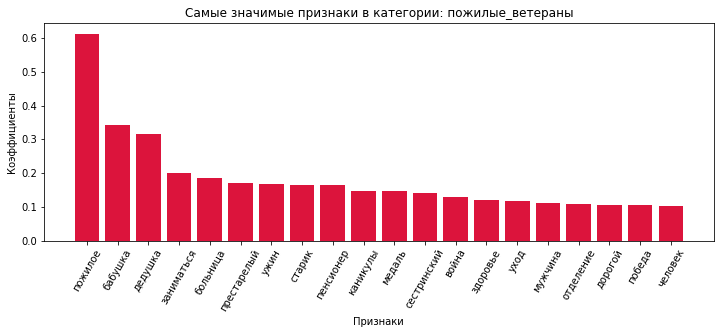

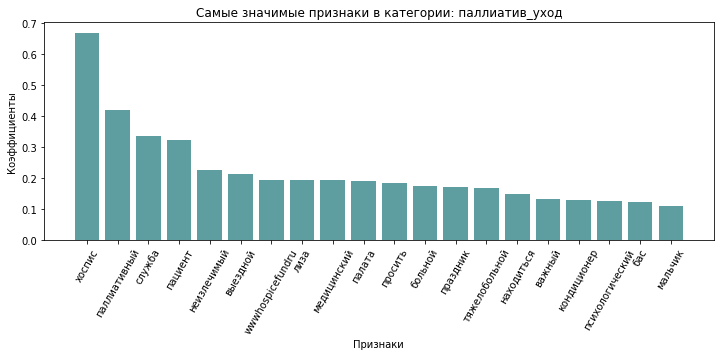

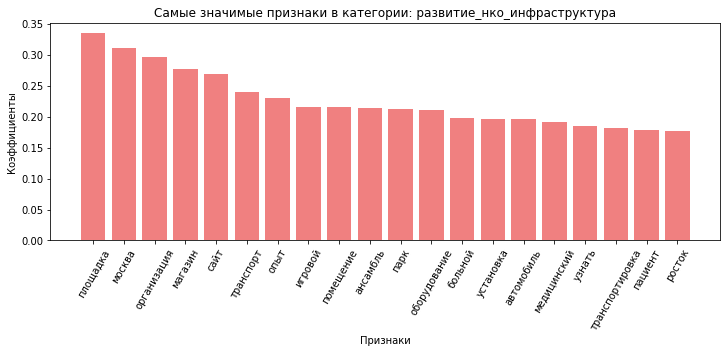

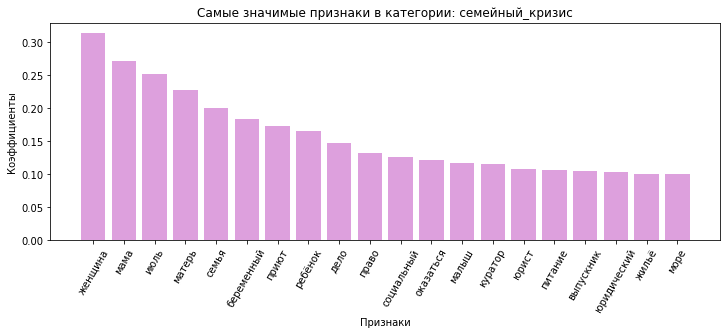

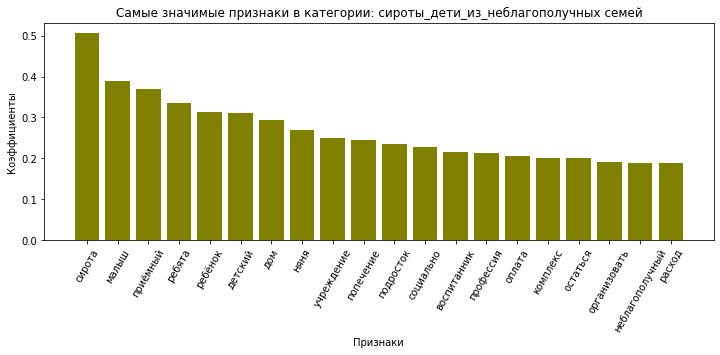

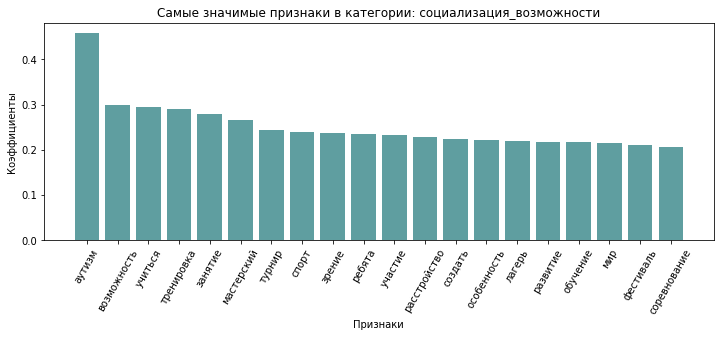

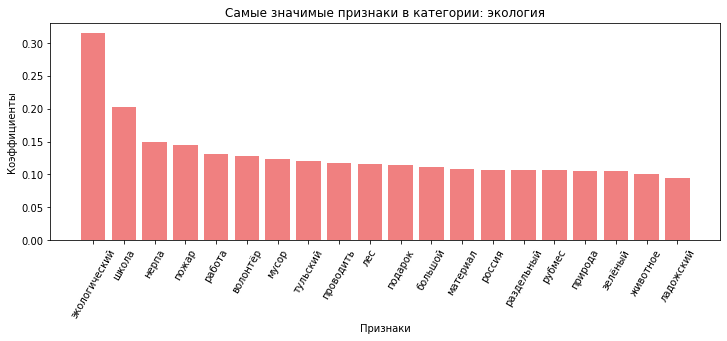

In [262]:
plot_top_features(class_label='активизм_просвещение_профилактика', max_top_features=20, color_given="plum")
plot_top_features(class_label='бездомные_кризис', max_top_features=20, color_given="cadetblue")
plot_top_features(class_label='взрослые_лечение_реабилитация', max_top_features=20, color_given="lightcoral")
plot_top_features(class_label='дети_лечение_реабилитация', max_top_features=20, color_given="bisque")
plot_top_features(class_label='животные', max_top_features=20, color_given="mediumaquamarine")
plot_top_features(class_label='заключенные', max_top_features=20, color_given="darkseagreen")
plot_top_features(class_label='малоимущие_бедность', max_top_features=20, color_given="plum")
plot_top_features(class_label='мечты_подарки_праздники', max_top_features=20, color_given="olive")
plot_top_features(class_label='наука_история_культура', max_top_features=20, color_given="lightsteelblue")
plot_top_features(class_label='пожилые_ветераны', max_top_features=20, color_given="crimson")
plot_top_features(class_label='паллиатив_уход', max_top_features=20, color_given="cadetblue")
plot_top_features(class_label='развитие_нко_инфраструктура', max_top_features=20, color_given="lightcoral")
plot_top_features(class_label='семейный_кризис', max_top_features=20, color_given="plum")
plot_top_features(class_label='сироты_дети_из_неблагополучных семей', max_top_features=20, color_given="olive")
plot_top_features(class_label='социализация_возможности', max_top_features=20, color_given="cadetblue")
plot_top_features(class_label='экология', max_top_features=20, color_given="lightcoral")

Confusion matrix не очень показательна в нашем случае, т.к. данных мало и много малочисленных классов в тестовой выборке. Если в тестовую выборку не попали экз. какого-то класса, то этого класса тут не будет.

In [232]:
confusion_matrix(y_test, clf.predict(X_test)) 

array([[  5,   0,   0,   3,   2,   0,   0,   1,   0,   0,   1,   1,   1,
          3,   4,   0],
       [  0,   6,   0,   0,   0,   0,   2,   0,   0,   0,   0,   1,   0,
          0,   0,   0],
       [  1,   0,   6,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   4,   0],
       [  0,   0,   2, 118,   0,   0,   0,   1,   0,   1,   0,   2,   0,
          3,   7,   0],
       [  0,   0,   0,   0,  61,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   6,   2,   0,   0,   1,   1,   1,
          4,   2,   0],
       [  0,   0,   0,   4,   0,   0,   0,  18,   0,   1,   0,   0,   0,
          0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   1,   0],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0,   9,   0,   0,   0,
          0,   1,   0],
       [  0,   0,   0,   0,   

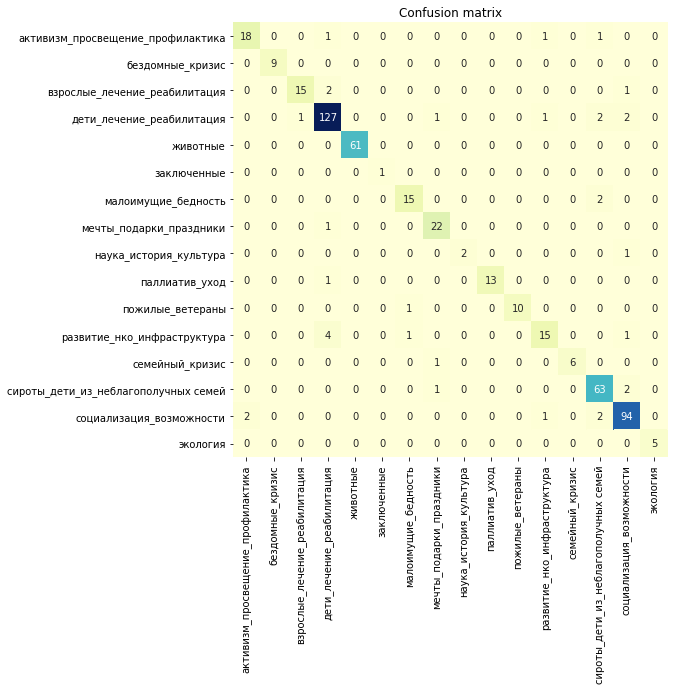

'Важно! Осторожнее с присвоением своих названий ticklelabels: график строится по "органическим" данным модели, а подписи задаются "искуственно" руками, поэтому если в тесте не оказалось какого-то класса, то соотношение съедет. По тем же причинам важен порядок элементов в спике названий.'

In [367]:
#%matplotlib inline #вшивает график в ячейку с кодом
categories = ['активизм_просвещение_профилактика', 'бездомные_кризис','взрослые_лечение_реабилитация',
              'дети_лечение_реабилитация', 'животные', 'заключенные', 'малоимущие_бедность', 
              'мечты_подарки_праздники', 'наука_история_культура', 'паллиатив_уход', 'пожилые_ветераны',
              'развитие_нко_инфраструктура', 'семейный_кризис', 'сироты_дети_из_неблагополучных семей',
              'социализация_возможности', 'экология']
plt.figure(figsize=(8,8)) # должно быть перед sns.heatmap
sns.heatmap(data=confusion_matrix(y_test, lr.predict(X_test)), annot=True, fmt='d', cbar=False, xticklabels=categories, yticklabels=categories, cmap="YlGnBu", square=True)
# fmt = String formatting code to use when adding annotations
plt.title("Confusion matrix")
plt.show()

"""Важно! Осторожнее с присвоением своих названий ticklelabels: график строится по "органическим" данным модели, а подписи задаются "искуственно" руками, поэтому если в тесте не оказалось какого-то класса, то соотношение съедет. По тем же причинам важен порядок элементов в спике названий."""

ROC график для 16 классов получается перегруженный, но в целом дает примерное представление, что чувствительность и специфичность можели очень разная к разным классам. Для его создания нужно адаптировать обучени под принцип one-vs-rest (подобие бинарной классификации, т.к. ROC работает только для бинарной).

In [335]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


X = df.Description
y = df.Category

# Binarize the output
y = label_binarize(y, classes=['активизм_просвещение_профилактика', 'бездомные_кризис','взрослые_лечение_реабилитация',
              'дети_лечение_реабилитация', 'животные', 'заключенные', 'малоимущие_бедность', 
              'мечты_подарки_праздники', 'наука_история_культура', 'паллиатив_уход', 'пожилые_ветераны',
              'развитие_нко_инфраструктура', 'семейный_кризис', 'сироты_дети_из_неблагополучных семей',
              'социализация_возможности', 'экология'])

n_classes = y.shape[1]

Xx_train, Xx_test, yy_train, yy_test = train_test_split(X, y, stratify = df.Category)

count = CountVectorizer()
ovr_lr = LogisticRegression(max_iter=1000)

Xx_train = count.fit_transform(Xx_train)

classifier = OneVsRestClassifier(lg_clf)
yy_score = classifier.fit(Xx_train, yy_train).decision_function(count.transform(Xx_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yy_test[:, i], yy_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yy_test.ravel(), yy_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

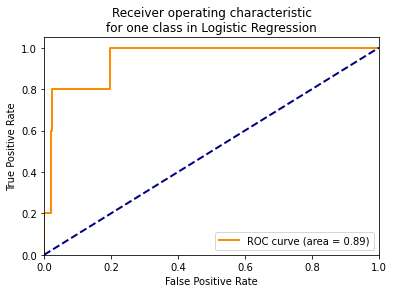

In [337]:
from itertools import cycle


plt.figure()
lw = 2
plt.plot(fpr[15], tpr[15], color='darkorange', # указ. индекс класса, для которого строим
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic\nfor one class in Logistic Regression')
plt.legend(loc="lower right")
plt.show()

<ipython-input-340-9d9d51e8394c>:6: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


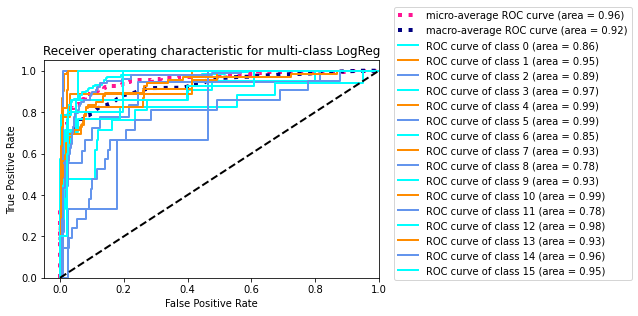

In [340]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class LogReg')
plt.legend(loc=9, bbox_to_anchor=(1.4,1.27))
#plt.legend(loc="lower right")
plt.show()

## Подвал: Попытки с другими моделями и параметрами

In [26]:
nb = MultinomialNB()
clf_1 = nb.fit(X_train, y_train)

In [27]:
print(classification_report(y_test, clf_1.predict(X_test)))

                                        precision    recall  f1-score   support

     активизм просвещение профилактика       0.00      0.00      0.00        21
                    бездомные и кризис       0.00      0.00      0.00        11
       взрослые лечение и реабилитация       0.00      0.00      0.00        14
           дети лечение и реабилитация       0.73      0.83      0.77       153
                              животные       0.76      1.00      0.87        52
                   малоимущие бедность       0.00      0.00      0.00        12
            мечты, подарки и праздники       1.00      0.14      0.25        28
                наука история культура       0.00      0.00      0.00         3
                      паллиатив и уход       1.00      0.07      0.13        14
                    пожилые и ветераны       0.00      0.00      0.00        12
         развитие нко и инфраструктура       0.00      0.00      0.00        23
                       семейный кризис 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
sv = SVC()
clf_2 = sv.fit(X_train, y_train)

In [59]:
print(classification_report(y_test, clf_2.predict(X_test)))

                                        precision    recall  f1-score   support

     активизм просвещение профилактика       0.00      0.00      0.00        20
                    бездомные и кризис       0.00      0.00      0.00         6
       взрослые лечение и реабилитация       0.00      0.00      0.00        23
           дети лечение и реабилитация       0.65      0.88      0.75       146
                              животные       0.93      0.88      0.90        64
                           заключенные       0.00      0.00      0.00         2
                   малоимущие бедность       0.00      0.00      0.00        13
            мечты, подарки и праздники       1.00      0.16      0.28        25
                наука история культура       0.00      0.00      0.00         3
                      паллиатив и уход       1.00      0.22      0.36         9
                    пожилые и ветераны       0.50      0.17      0.25         6
         развитие нко и инфраструктура 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
dt = DecisionTreeClassifier()
clf_3 = dt.fit(X_train, y_train)

In [61]:
print(classification_report(y_test, clf_3.predict(X_test)))

                                        precision    recall  f1-score   support

     активизм просвещение профилактика       0.06      0.05      0.05        20
                    бездомные и кризис       0.25      0.50      0.33         6
       взрослые лечение и реабилитация       0.22      0.17      0.20        23
           дети лечение и реабилитация       0.67      0.66      0.66       146
                              животные       0.87      0.81      0.84        64
                           заключенные       0.00      0.00      0.00         2
                   малоимущие бедность       0.08      0.15      0.10        13
            мечты, подарки и праздники       0.35      0.24      0.29        25
                наука история культура       0.00      0.00      0.00         3
                      паллиатив и уход       0.50      0.67      0.57         9
                    пожилые и ветераны       0.18      0.33      0.24         6
         развитие нко и инфраструктура 

In [62]:
rf = RandomForestClassifier()
clf_4 = rf.fit(X_train, y_train)

In [63]:
print(classification_report(y_test, clf_4.predict(X_test)))

                                        precision    recall  f1-score   support

     активизм просвещение профилактика       0.00      0.00      0.00        20
                    бездомные и кризис       1.00      0.17      0.29         6
       взрослые лечение и реабилитация       1.00      0.09      0.16        23
           дети лечение и реабилитация       0.63      0.92      0.75       146
                              животные       0.93      0.98      0.95        64
                           заключенные       0.00      0.00      0.00         2
                   малоимущие бедность       0.50      0.08      0.13        13
            мечты, подарки и праздники       1.00      0.28      0.44        25
                наука история культура       0.00      0.00      0.00         3
                      паллиатив и уход       1.00      0.33      0.50         9
                    пожилые и ветераны       0.60      0.50      0.55         6
         развитие нко и инфраструктура 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
kn = KNeighborsClassifier()
clf_5 = kn.fit(X_train, y_train)

In [65]:
print(classification_report(y_test, clf_5.predict(X_test)))

                                        precision    recall  f1-score   support

     активизм просвещение профилактика       0.14      0.15      0.15        20
                    бездомные и кризис       0.33      0.50      0.40         6
       взрослые лечение и реабилитация       0.36      0.22      0.27        23
           дети лечение и реабилитация       0.62      0.82      0.71       146
                              животные       0.62      0.86      0.72        64
                           заключенные       0.00      0.00      0.00         2
                   малоимущие бедность       0.11      0.23      0.15        13
            мечты, подарки и праздники       0.20      0.12      0.15        25
                наука история культура       0.00      0.00      0.00         3
                      паллиатив и уход       0.41      0.78      0.54         9
                    пожилые и ветераны       0.67      0.33      0.44         6
         развитие нко и инфраструктура 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
#GridSearch для лог. регрессии работает примерно 1ч.20 мин.

grid_values = {'penalty': ['l1', 'l2', 'elastinet', 'none'],
               'C':[0.001,.009,0.01,.09,1,5,10,25], 
               'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
               'class_weight': ['balanced', 'none']}
gs_lr = GridSearchCV(lr, param_grid = grid_values)
gs_clf = gs_lr.fit(X_train, y_train)
print(gs_clf.best_params_) 

#вот что из предложенного GS счел лучшим:
#{'C': 0.09, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go